In [3]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.2 MB/s eta 0:00:00eta 0:00:01


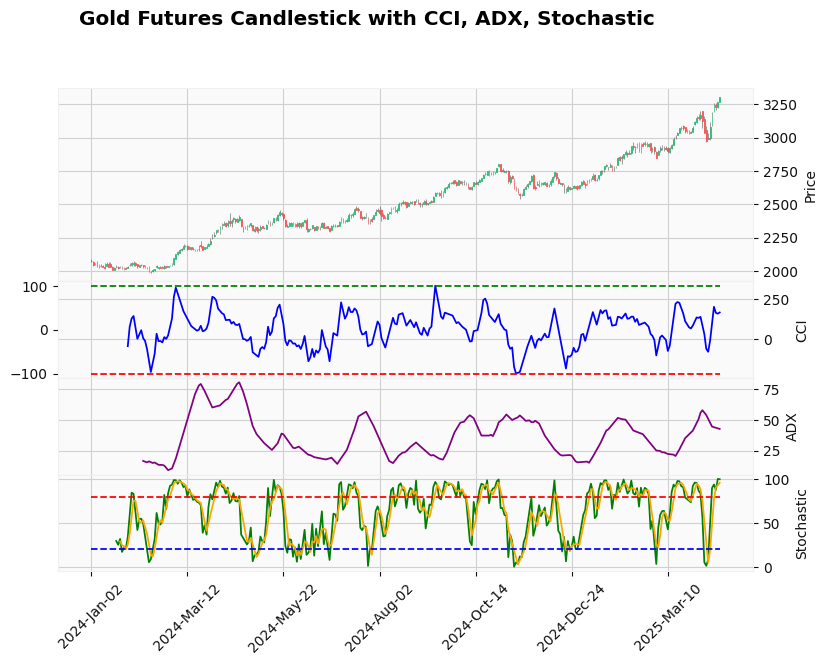

In [4]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ---- Load your data ----
origin_df = pd.read_csv('../Gold Futures Historical Data.csv')
origin_df.dropna(inplace=True)

df = origin_df[['Date', 'Price','Open','High' ,'Low']]
df = df.rename(columns={
    'Date': 'date_time',
    'Price': 'close',
    'Open': 'open',
    'High': 'high',
    'Low': 'low'
})

df['date_time'] = pd.to_datetime(df['date_time'])
for col in ['open', 'high', 'low', 'close']:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

df = df.sort_values('date_time', ascending=True).reset_index(drop=True)
df.set_index('date_time', inplace=True)

# ---- CCI Calculation ----
n = 20
tp = (df['high'] + df['low'] + df['close']) / 3
sma_tp = tp.rolling(window=n).mean()
mad = tp.rolling(window=n).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
df['CCI'] = (tp - sma_tp) / (0.015 * mad)

# ---- ADX Calculation ----
adx_period = 14
df['TR'] = np.maximum(df['high'] - df['low'],
                      np.maximum(abs(df['high'] - df['close'].shift(1)),
                                 abs(df['low'] - df['close'].shift(1))))
df['+DM'] = np.where((df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']),
                     df['high'] - df['high'].shift(1), 0)
df['-DM'] = np.where((df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)),
                     df['low'].shift(1) - df['low'], 0)

df['TR_smooth'] = df['TR'].rolling(window=adx_period).mean()
df['+DM_smooth'] = df['+DM'].rolling(window=adx_period).mean()
df['-DM_smooth'] = df['-DM'].rolling(window=adx_period).mean()

df['+DI'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
df['-DI'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
df['ADX'] = df['DX'].rolling(window=adx_period).mean()

# ---- Stochastic Oscillator ----
stoch_period = 14
df['%K'] = 100 * (df['close'] - df['low'].rolling(window=stoch_period).min()) / \
           (df['high'].rolling(window=stoch_period).max() - df['low'].rolling(window=stoch_period).min())
df['%D'] = df['%K'].rolling(window=3).mean()

# ---- Plotting with mplfinance ----
apds = [
    mpf.make_addplot(df['CCI'], panel=1, color='blue', ylabel='CCI'),
    mpf.make_addplot(df['ADX'], panel=2, color='purple', ylabel='ADX'),
    mpf.make_addplot(df['%K'], panel=3, color='green', ylabel='Stochastic'),
    mpf.make_addplot(df['%D'], panel=3, color='orange'),
    mpf.make_addplot([100]*len(df), panel=1, color='green', linestyle='--'),
    mpf.make_addplot([-100]*len(df), panel=1, color='red', linestyle='--'),
    mpf.make_addplot([80]*len(df), panel=3, color='red', linestyle='--'),
    mpf.make_addplot([20]*len(df), panel=3, color='blue', linestyle='--')
]

mpf.plot(df,
         type='candle',
         style='yahoo',
         title='Gold Futures Candlestick with CCI, ADX, Stochastic',
         volume=False,
         addplot=apds,
         panel_ratios=(2, 1, 1, 1),
         figratio=(14, 10),
         figscale=1.2)
